<a href="https://colab.research.google.com/github/lnsayer/personal_repo/blob/main/amazon_node_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Dataset (from PyTorch Geometric) Node Classification Project

The Amazon Computers and Amazon Photo networks from the “Pitfalls of Graph Neural Network Evaluation” paper. Nodes represent goods and edges represent that two goods are frequently bought together. Given product reviews as bag-of-words node features, the task is to map goods to their respective product category.

In [2]:
# Install necessary libraries into Colab which are not pre-installed
!pip install torch_geometric
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 4.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux

In [34]:
# Import necessary libraries
from torch_geometric.datasets import Amazon
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassAUROC
from torchmetrics.classification import MulticlassConfusionMatrix
from timeit import default_timer as timer
from torch_geometric.nn import GATConv
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [35]:
# instantiating the dataset. Can be found here: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Amazon.html#torch_geometric.datasets.Amazon
dataset = Amazon(root="data/Amazon", name="Computers")

# Obtaining data object from dataset
data = dataset[0]

# Printing descriptors of the graph
print(f"Number of nodes in graph is: {data.x.shape[0]}")
print(f"Number of features for each node is {dataset.num_features}")
print(f"Number of edges is {data.edge_index.shape[1]}")
print(f"We want to predict the classes of the 13752 Computers\n")
print(f"Data object is {data}\n")

print(f"The number of class members for each class: {dataset.num_classes}\n")
print(f"Class labels and their frequencies: \n{data.y.unique(return_counts=True)}")

Number of nodes in graph is: 13752
Number of features for each node is 767
Number of edges is 491722
We want to predict the classes of the 13752 Computers

Data object is Data(x=[13752, 767], edge_index=[2, 491722], y=[13752])

The number of class members for each class: 10

Class labels and their frequencies: 
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([ 436, 2142, 1414,  542, 5158,  308,  487,  818, 2156,  291]))


In [36]:
# # We will split the data using a transductive method in which the whole input graph is put through the forward method however
# we split the labels (classes) for the loss function. We will use a split of train: 80%, val: 10% and test: 10%.
torch.manual_seed(42)
# indices of the nodes randomly shuffled
indices = torch.randperm(data.x.shape[0])
print(f"Shuffled indices are {indices} of length {len(indices)}\n")

# Splits: train:80%, val:10% and test:10%
train_indices = indices[:int(0.8*len(indices))]
val_indices = indices[int(0.8*len(indices)):int(0.9*len(indices))]
test_indices = indices[int(0.9*len(indices)):]
print(f"Train shuffled indices are {train_indices} of length {len(train_indices)}\n")
print(f"Test shuffled indices are {test_indices} of length {len(test_indices)}\n")
print(f"Validation shuffled indices are {val_indices} of length {len(val_indices)}\n")

# train labels to pass - end up not using these (for readability)
train_labels = data.y[train_indices]
val_labels = data.y[val_indices]
test_labels = data.y[test_indices]


Shuffled indices are tensor([11094,  1027,  4378,  ...,  8275,  9941,  4338]) of length 13752

Train shuffled indices are tensor([11094,  1027,  4378,  ...,  8049, 12835,    92]) of length 11001

Test shuffled indices are tensor([8461, 5630, 8059,  ..., 8275, 9941, 4338]) of length 1376

Validation shuffled indices are tensor([  794,  4772,  8150,  ..., 12435,   687,  5437]) of length 1375



In [37]:
# Tells us if the edges of the graph are undirected
data.is_undirected()

True

In [38]:
# Create a model

# Set number of hidden channels
nb_hidden_channels = 32

# Class for simple GCN classifier. Returns log softmax (log of the probabilities). This architecture is taken from this paper: https://arxiv.org/abs/1609.02907
class GCN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    # First layer
    self.conv1 = GCNConv(in_channels = dataset.num_features,
                         out_channels = nb_hidden_channels)
    # Second layer (classifier)
    self.conv2 = GCNConv(in_channels = nb_hidden_channels,
                         out_channels = dataset.num_classes)

  # Forward function, returns log of probabilities
  def forward(self, data):
    x, edge_index = data.x, data.edge_index

    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    x = F.log_softmax(x, dim=1)

    return x

# Defined it later too
gcn_model = GCN()
gcn_model


GCN(
  (conv1): GCNConv(767, 32)
  (conv2): GCNConv(32, 10)
)

In [92]:
# Run training
torch.manual_seed(42)

# Set device as GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
# Instantiate the gcn_model
gcn_model = GCN()
# Move the model to the gpu (or cpu if not available)
gcn_model = gcn_model.to(device)

# Using Adam for stochastic optimisation
optimiser = torch.optim.Adam(gcn_model.parameters(), lr=0.01)
# Negative loss likelihood for the loss function
loss_fn = torch.nn.NLLLoss()

# define the data and move to device
data = dataset[0]
data = data.to(device)

# Set the number of epochs to train for
nb_epochs = 401

# Create arrays to append train/test accuracy/loss values
epochs = np.arange(0, nb_epochs)
train_loss_array = np.zeros(nb_epochs)
train_acc_array = np.zeros(nb_epochs)
test_loss_array = np.zeros(nb_epochs)
test_acc_array = np.zeros(nb_epochs)

start_time = timer()

# Train and test loop
for epoch in range(nb_epochs):
  ### Train ###

  # Forward pass on the network
  gcn_model.train()
  out = gcn_model(data)

  # Falculate the loss
  loss = loss_fn(out[train_indices], data.y[train_indices])

  # Falculate the label (log) probabilities
  label_probs = out[train_indices]
  # Calculate the label predictions
  label_preds = torch.argmax(label_probs, dim=1)
  # Calculate accuracy
  accuracy = (label_preds == data.y[train_indices]).sum()/len(label_preds)

  # Append loss/accuracy values to array
  train_loss_array[epoch] = loss
  train_acc_array[epoch] = accuracy

  # Zero the gradients
  optimiser.zero_grad()
  # Backpropagate the loss
  loss.backward()
  # Update the optimizer
  optimiser.step()

  ### Test ###

  # Put the model into eval mode
  gcn_model.eval()
  with torch.inference_mode():
    # Calculate the loss for the test set
    test_loss = loss_fn(out[test_indices], data.y[test_indices])

    # Calculate the predictions for the test set and then calculate the accuracy
    test_label_probs = out[test_indices]
    test_label_preds = torch.argmax(test_label_probs, dim=1)
    test_accuracy = (test_label_preds == data.y[test_indices]).sum()/len(test_label_preds)

    # Append loss/accuracy values to array
    test_loss_array[epoch] = test_loss
    test_acc_array[epoch] = test_accuracy

  # Print out results
  if epoch % 10 == 0:
    print(f"Epoch: {epoch}, Train Loss: {loss:.4f}, Train Accuracy: {accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
end_time = timer()

print(f"Time to train and print test results: {end_time - start_time:.3f} seconds")

Epoch: 0, Train Loss: 2.4572, Train Accuracy: 0.1576, Test Loss: 2.4824, Test Accuracy: 0.1468
Epoch: 10, Train Loss: 1.9014, Train Accuracy: 0.4634, Test Loss: 1.9303, Test Accuracy: 0.4455
Epoch: 20, Train Loss: 1.4656, Train Accuracy: 0.6603, Test Loss: 1.5017, Test Accuracy: 0.6257
Epoch: 30, Train Loss: 1.2304, Train Accuracy: 0.6843, Test Loss: 1.2750, Test Accuracy: 0.6533
Epoch: 40, Train Loss: 1.0095, Train Accuracy: 0.7311, Test Loss: 1.0531, Test Accuracy: 0.6999
Epoch: 50, Train Loss: 0.8497, Train Accuracy: 0.7476, Test Loss: 0.8849, Test Accuracy: 0.7246
Epoch: 60, Train Loss: 0.7312, Train Accuracy: 0.7957, Test Loss: 0.7653, Test Accuracy: 0.7718
Epoch: 70, Train Loss: 0.6261, Train Accuracy: 0.8279, Test Loss: 0.6593, Test Accuracy: 0.8060
Epoch: 80, Train Loss: 0.5473, Train Accuracy: 0.8497, Test Loss: 0.5782, Test Accuracy: 0.8256
Epoch: 90, Train Loss: 0.4906, Train Accuracy: 0.8649, Test Loss: 0.5264, Test Accuracy: 0.8445
Epoch: 100, Train Loss: 0.4496, Train Acc

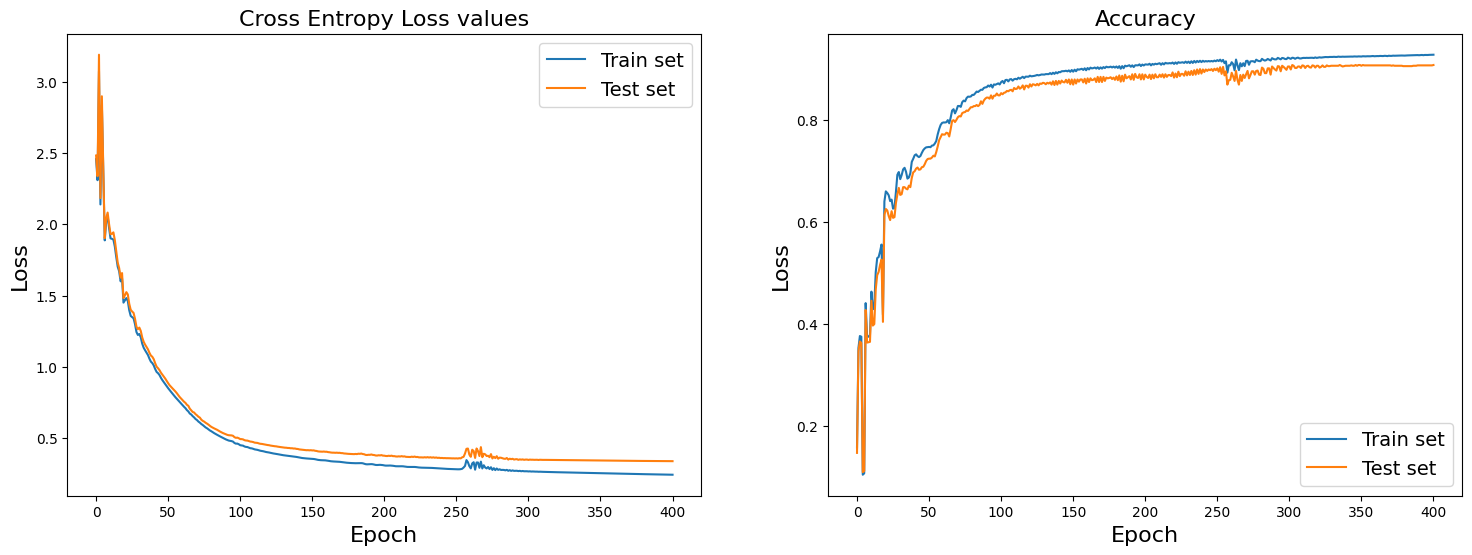

In [40]:
# Create figures and axes
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot train/test loss/accuracy values
ax0.plot(epochs, train_loss_array, label = "Train set")
ax0.plot(epochs, test_loss_array, label = "Test set")

ax1.plot(epochs, train_acc_array, label="Train set")
ax1.plot(epochs, test_acc_array, label = "Test set")

# Descriptors of graphs
ax0.set_xlabel("Epoch", size=16)
ax0.set_ylabel("Loss", size=16)

ax1.set_xlabel("Epoch", size=16)
ax1.set_ylabel("Loss", size=16)

ax0.legend(fontsize=14);
ax1.legend(fontsize=14);

ax0.set_title("Cross Entropy Loss values", size=16);
ax1.set_title("Accuracy", size=16);

In [41]:
# Calculate the AUC (area under the curve) of the GCN model
auc_metric = MulticlassAUROC(num_classes=dataset.num_classes, average="macro", thresholds=None)

train_auc = auc_metric(label_probs, data.y[train_indices])
test_auc = auc_metric(test_label_probs, data.y[test_indices])

print(f"Train AUC: {train_auc:.4f}, Test AUC: {test_auc:.4f}")

Train AUC: 0.9940, Test AUC: 0.9897


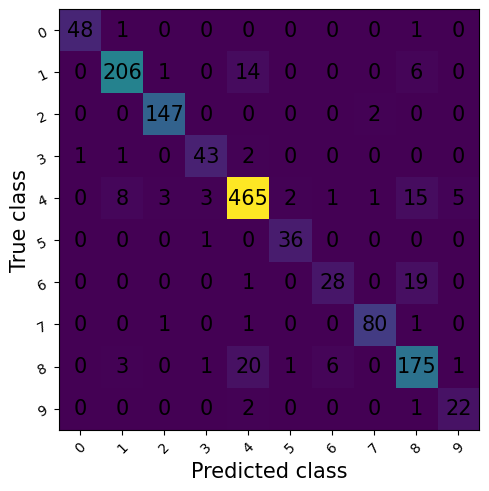

In [42]:
# Plot confusion matrix of the true and predicted classes
conf_matrix_metric = MulticlassConfusionMatrix(num_classes = dataset.num_classes).to(device)

test_conf_matrix = conf_matrix_metric(test_label_preds, data.y[test_indices])

fig_, ax_ = conf_matrix_metric.plot()

In [43]:
# Create a GAT network (graph attention network). Taken from https://arxiv.org/abs/1710.10903

nb_hidden_channels = 32

# Class for GAT network. Two layers with a non-linear activation function (ReLU) after the first layer. Dropout also after the first layer to prevent
# overfitting. Returns log of the probabilities (log softmax). Uses 8 attention heads to capture different features of the nodes. The first layer's
# encoded features are concatenated and the second layer's features are averaged, as can be seen in the paper.

class GAT(torch.nn.Module):
  def __init__(self):
    super().__init__()
    # First layer
    self.conv1 = GATConv(in_channels = dataset.num_features,
                         out_channels = nb_hidden_channels,
                         heads = 8,
                         concat = True)
    # Second layer
    self.conv2 = GATConv(in_channels = nb_hidden_channels*8,
                         out_channels = dataset.num_classes,
                         heads = 1,
                         concat = False)
  # Forward method
  def forward(self, data):
    x, edge_index = data.x, data.edge_index

    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = F.dropout(x)
    x = self.conv2(x, edge_index)
    x = F.log_softmax(x, dim=1)

    return x

# Instantiate the model
gat_model = GAT()
gat_model

GAT(
  (conv1): GATConv(767, 32, heads=8)
  (conv2): GATConv(256, 10, heads=1)
)

In [86]:
# Run training
torch.manual_seed(42)

# set device as GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
# instantiate the gcn_model
gat_model = GAT()
# move the model to the gpu (or cpu is not available)
gat_model = gat_model.to(device)

# Using Adam for stochastic optimisation
optimiser = torch.optim.Adam(gat_model.parameters(), lr=0.001)
# Negative loss likelihood for the loss function
loss_fn = torch.nn.NLLLoss()

# define the data
data = dataset[0]
data = data.to(device)

# Set number of epochs to train on
nb_epochs = 401

# Create arrays to append train/test loss values to
epochs = np.arange(0, nb_epochs)
gat_train_loss_array = np.zeros(nb_epochs)
gat_train_acc_array = np.zeros(nb_epochs)
gat_test_loss_array = np.zeros(nb_epochs)
gat_test_acc_array = np.zeros(nb_epochs)

# Time the training/test loop
start_time = timer()

# Train and test loop
for epoch in range(nb_epochs):
  ### Train ###

  # forward pass on the network
  gat_model.train()
  gat_out = gat_model(data)

  # Calculate the loss
  gat_loss = loss_fn(gat_out[train_indices], data.y[train_indices])

  # Calculate the label probabilities
  gat_label_probs = gat_out[train_indices]
  # Calculate the label predictions
  gat_label_preds = torch.argmax(gat_label_probs, dim=1)
  # Calculate accuracy
  gat_accuracy = (gat_label_preds == data.y[train_indices]).sum()/len(gat_label_preds)

  # Append loss/accuracy values
  gat_train_loss_array[epoch] = gat_loss
  gat_train_acc_array[epoch] = gat_accuracy

  # Zero the gradients
  optimiser.zero_grad()
  # Backpropagate the loss
  gat_loss.backward()
  # Update the optimizer
  optimiser.step()

  ### Test ###

  # Put the model into eval mode
  gat_model.eval()
  with torch.inference_mode():
    # Calculate the loss for the test set
    gat_test_loss = loss_fn(gat_out[test_indices], data.y[test_indices])

    # Calculate the predictions for the test set and then calculate the accuracy
    gat_test_label_probs = gat_out[test_indices]
    gat_test_label_preds = torch.argmax(gat_test_label_probs, dim=1)
    gat_test_accuracy = (gat_test_label_preds == data.y[test_indices]).sum()/len(gat_test_label_preds)

    gat_test_loss_array[epoch] = gat_test_loss
    gat_test_acc_array[epoch] = gat_test_accuracy

  # Print out train/test accuracy/loss values at each epoch
  if epoch % 10 == 0:
    print(f"Epoch: {epoch}, Train Loss: {gat_loss:.4f}, Train Accuracy: {gat_accuracy:.4f}, Test Loss: {gat_test_loss:.4f}, Test Accuracy: {gat_test_accuracy:.4f}")

end_time = timer()

print(f"Time to train and print test results: {end_time - start_time:.3f} seconds")

Epoch: 0, Train Loss: 2.6429, Train Accuracy: 0.1205, Test Loss: 2.6339, Test Accuracy: 0.1214
Epoch: 10, Train Loss: 1.5029, Train Accuracy: 0.5476, Test Loss: 1.5419, Test Accuracy: 0.5189
Epoch: 20, Train Loss: 1.0721, Train Accuracy: 0.6965, Test Loss: 1.1084, Test Accuracy: 0.6759
Epoch: 30, Train Loss: 0.8049, Train Accuracy: 0.7571, Test Loss: 0.8380, Test Accuracy: 0.7355
Epoch: 40, Train Loss: 0.6382, Train Accuracy: 0.8054, Test Loss: 0.6609, Test Accuracy: 0.7776
Epoch: 50, Train Loss: 0.5317, Train Accuracy: 0.8409, Test Loss: 0.5720, Test Accuracy: 0.8249
Epoch: 60, Train Loss: 0.4636, Train Accuracy: 0.8596, Test Loss: 0.4996, Test Accuracy: 0.8474
Epoch: 70, Train Loss: 0.4160, Train Accuracy: 0.8735, Test Loss: 0.4539, Test Accuracy: 0.8634
Epoch: 80, Train Loss: 0.3840, Train Accuracy: 0.8855, Test Loss: 0.4193, Test Accuracy: 0.8699
Epoch: 90, Train Loss: 0.3580, Train Accuracy: 0.8899, Test Loss: 0.3980, Test Accuracy: 0.8728
Epoch: 100, Train Loss: 0.3317, Train Acc

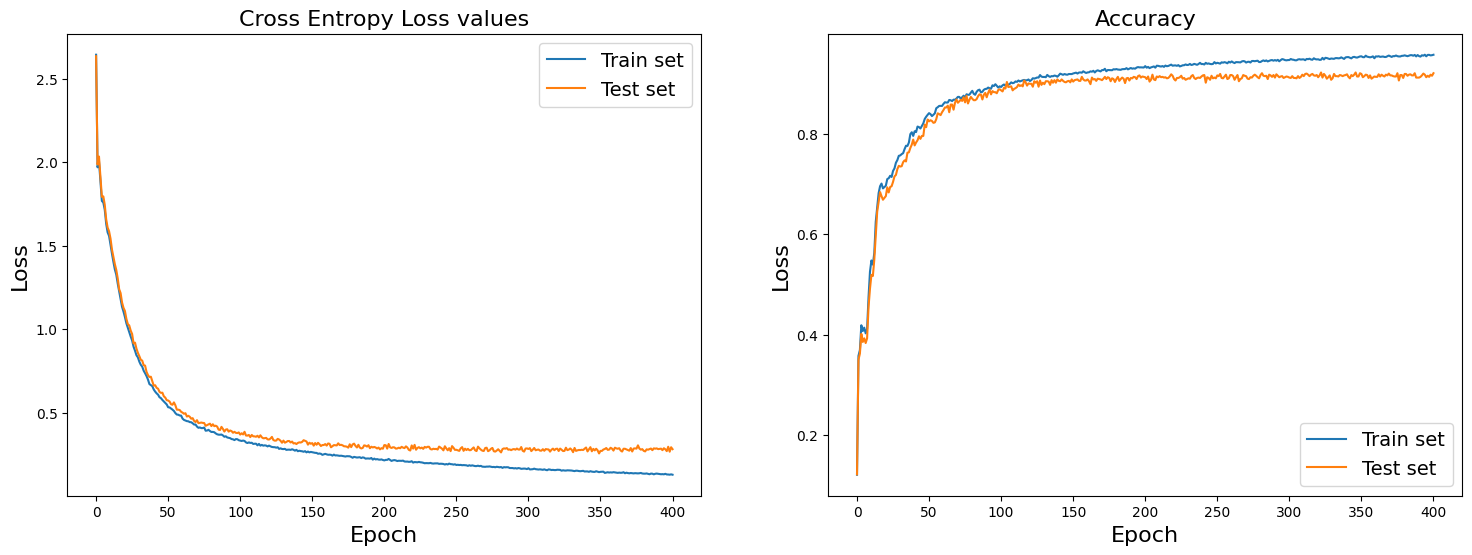

In [45]:
# Create figure and axes
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot the train/test loss/accuracy
ax0.plot(epochs, gat_train_loss_array, label = "Train set")
ax0.plot(epochs, gat_test_loss_array, label = "Test set")

ax1.plot(epochs, gat_train_acc_array, label="Train set")
ax1.plot(epochs, gat_test_acc_array, label = "Test set")

# Add descriptors
ax0.set_xlabel("Epoch", size=16)
ax0.set_ylabel("Loss", size=16)

ax1.set_xlabel("Epoch", size=16)
ax1.set_ylabel("Loss", size=16)

ax0.legend(fontsize=14);
ax1.legend(fontsize=14);

ax0.set_title("Cross Entropy Loss values", size=16);
ax1.set_title("Accuracy", size=16);

## Comparisons of the models:

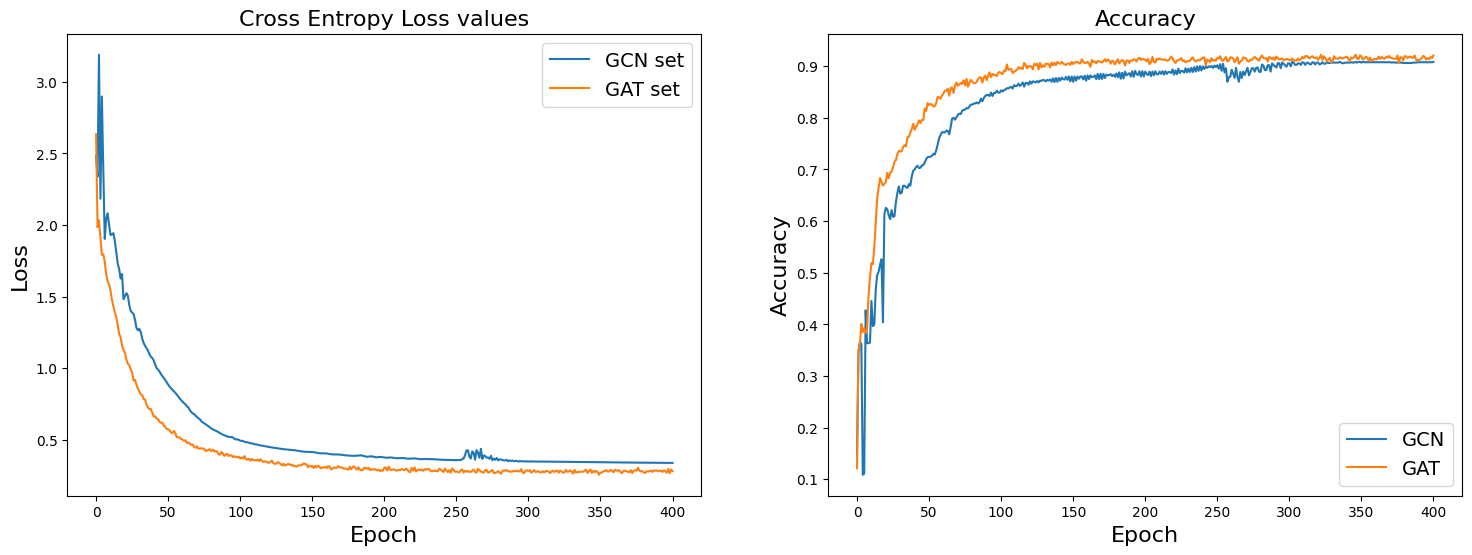

In [49]:
# Create figure and axes
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot the train/test loss/accuracy
ax0.plot(epochs, test_loss_array, label = "GCN set")
ax0.plot(epochs, gat_test_loss_array, label = "GAT set")

ax1.plot(epochs, test_acc_array, label="GCN")
ax1.plot(epochs, gat_test_acc_array, label = "GAT")

# Add descriptors
ax0.set_xlabel("Epoch", size=16)
ax0.set_ylabel("Loss", size=16)

ax1.set_xlabel("Epoch", size=16)
ax1.set_ylabel("Accuracy", size=16)

ax0.legend(fontsize=14);
ax1.legend(fontsize=14);

ax0.set_title("Cross Entropy Loss values", size=16);
ax1.set_title("Accuracy", size=16);

In [107]:
from torchmetrics.classification import MulticlassROC

roc_metric = MulticlassROC(num_classes=dataset.num_classes, thresholds=50)

print(gat_test_label_probs.shape)
print(data.y[test_indices].shape)

gcn_fpr, gcn_tpr, gcn_thresholds = roc_metric(test_label_probs, data.y[test_indices])
gat_fpr, gat_tpr, gat_thresholds = roc_metric(gat_test_label_probs, data.y[test_indices])


print(gcn_fpr)

fig, ax = plt.subplots(figsize=(8, 8))




"""
for i in range(dataset.num_classes):
  ax.plot(gcn_fpr[i].cpu().numpy(), gcn_tpr[i].cpu().numpy(), c='#1f77b4', alpha = 0.5)
  ax.plot(gat_fpr[i].cpu().numpy(), gat_tpr[i].cpu().numpy(), c='#ff7f0e', alpha = 0.5)

"""



torch.Size([1376, 10])
torch.Size([1376])


RuntimeError: Encountered different devices in metric calculation (see stacktrace for details). This could be due to the metric class not being on the same device as input. Instead of `metric=MulticlassROC(...)` try to do `metric=MulticlassROC(...).to(device)` where device corresponds to the device of the input.